In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from helper_functions import *

In [4]:
import pandas as pd
from tqdm.notebook import tqdm
import re
from typing import List
import os
import matplotlib.pyplot as plt
import numpy as np
import artm
from collections import defaultdict

In [5]:
%%time
df = pd.read_excel('../data/avtoreferati.xlsx', sheet_name='Итог', header=0)

CPU times: user 4.06 s, sys: 47.3 ms, total: 4.11 s
Wall time: 4.11 s


In [6]:
# df.columns

In [7]:
df['Пункты паспорта специальности (области исследования) 1-ой специальности'].head(3)

0      2.5
1        3
2    3,4,5
Name: Пункты паспорта специальности (области исследования) 1-ой специальности, dtype: object

In [8]:
tasks_aux = {k: f't{k}' for k in range(1, 14)}
# 1: 't1', 2: 't2', 3: 't3', 4: 't4', 5: 't5', 6: 't6', 7: 't7', 8: 't8', 9: 't9', 10: 't10', 11: 't11', 12: 't12', 13: 't13'
res_aux = {f'{k}.1' : f'r{k}' for k in range(1, 14)}

res_aux.update({k: f'r{k}' for k in range(14, 21)})

In [9]:
df.rename(
    columns={'Годзащиты': 'year', 'Unnamed: 29': 'title', 
             'Пункты паспорта специальности (области исследования) 1-ой специальности': 'code',
            **tasks_aux,
            **res_aux,}, 
    inplace=True
)

In [10]:
df.year[~df.year.isna()].shape, df.shape

((5793,), (5798, 64))

In [11]:
df = df[['year', 'code', *list(res_aux.values())]]

In [12]:
df = df[~df.year.isna()]
df['year'] = df.year.astype(int)
df['code'] = df.code.replace('?', np.nan)

### Работа с колонкой `code`

In [14]:
def preprocess_code_column(values: list) -> pd.Series:
    res = []
    comp = re.compile(r'[.,]')
    chars = re.compile(r'[^0-9.,]')
    str2int = lambda lst: list(map(int, lst))
    for i, val_ in enumerate(values):
        val = str(val_)
        val = re.sub(chars, '', val)
        codes = comp.split(val)
        codes = [c.strip() for c in codes if c.strip()]
        codes = str2int(codes)
        res.append(codes)
    return res

In [16]:
df = df.dropna(subset=[f'r{i}' for i in range(1, 21)], how='all')

In [17]:
df.shape

(2724, 22)

https://stackoverflow.com/questions/66821858/pandas-dataframe-isnull-multiple-columns-at-once

In [19]:
code = df.code.astype('str').tolist()
assert len(code) == df.shape[0]

In [20]:
df['code'] = preprocess_code_column(code)

### рассматриваем только результаты (без задач)

In [21]:
df['text'] = df.apply(lambda row: \
    '. '.join([row[f'r{i}'] for i in range(1, 21) if isinstance(row[f'r{i}'], str)]),
    axis=1
)

In [22]:
df.shape

(2724, 23)

### Preprocessing

In [23]:
import pymorphy2
import os
from typing import List
import razdel

import nltk
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('russian')

cyrillic = re.compile(r'[^а-я ]')
mult_ws = re.compile(r'\s+')
fix_punct = re.compile(r'\s+(\?|\.|,|!|:)')

morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /home/robez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/home/robez/ds_venv2/lib/python3.8/site-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [24]:
def process_regex(re_words_to_remove,
                  re_mult_ws,
                  text: str) -> str:
    '''
    строковый предпроцессинг предложения
    '''
    text = text.lower()
    text = re.sub(re_words_to_remove, ' ', text)
    text = re.sub(re_mult_ws, ' ', text)
    text = text.strip()
    return text

def lemmatize(text: str, lemmatizer, min_word_size: int = 5) -> List[str]:
    words = [token.text for token in razdel.tokenize(text)]
    res = []
    for word in words:
        if word not in stopwords:# and len(word) > 1:
            p = lemmatizer.parse(word)[0]
            word_normal_form = p.normal_form
            if len(word_normal_form) < min_word_size:
                continue
            res.append(word_normal_form.replace('ё', 'е'))
    return res

def process_doc(doc: List[str], lemmatizer, min_word_size=3, min_sent_size=10) -> List[str]:
    proc_doc = []
    if not isinstance(doc, list):
        doc = [doc]
    for sent in doc:
        proc_sent = process_regex(
            cyrillic,
            mult_ws,
            text=sent
        )
        proc_sent_tokens = lemmatize(proc_sent, lemmatizer, min_word_size)
        # порог по длине предложения
        if len(proc_sent_tokens) < min_sent_size:
            continue
        proc_sent = ' '.join(proc_sent_tokens)
        proc_doc.append(proc_sent)
    return proc_doc

def sentenize_doc(doc: str) -> List[str]:
    return [sent.text for sent in razdel.sentenize(doc) if sent.text]

In [25]:
df['text_sent'] = df.text.apply(lambda row: sentenize_doc(row))

In [26]:
%%time
df['text_sent_proc'] = df.text_sent.apply(
    lambda row: process_doc(
                            row,
                            lemmatizer=morph,
                            min_word_size=2,
                            min_sent_size=5
    )
)

CPU times: user 1min 22s, sys: 35 ms, total: 1min 22s
Wall time: 1min 22s


In [28]:
%%time
df['text_clean'] = df.text_sent_proc.apply(lambda row:
                                           ' '.join(row)
                                          )

CPU times: user 7.91 ms, sys: 8 ms, total: 15.9 ms
Wall time: 15.6 ms


In [29]:
# проверяем пустые тексты после обработкиы
df.text_clean = df.text_clean.replace('', np.nan) #.replace('\n', np.nan)
df.text_clean[df.text_clean.isna()]

24      NaN
64      NaN
73      NaN
85      NaN
159     NaN
301     NaN
432     NaN
528     NaN
647     NaN
800     NaN
1168    NaN
1379    NaN
3355    NaN
Name: text_clean, dtype: object

In [30]:
df.text_clean[df.text_clean.isna()].shape

(13,)

In [31]:
df = df[~df.text_clean.isna()]

In [32]:
# df.dropna(inplace=True)

#### Сохранение текста, годов и кодов после препроцессинга, но до TF-IDF

In [33]:
texts = df.text_clean.tolist()
years = df.year.tolist()
codes = df.code.tolist()

In [34]:
len(texts)

2711

#### сохранение текстов для классификации

In [35]:
import json

with open('saved_content/procced_texts_full_vocab.txt', 'w') as fh:
    fh.writelines([f'{text}\n' for text in texts])

with open('saved_content/metadata.json', 'w') as fh:
    json.dump({'codes': codes, 'years': years}, fh)

In [36]:
# with open('texts.txt') as fh:
#     texts = fh.readlines()

In [37]:
def convert_texts_to_tokens(texts):
    return [text.split() for text in texts]

In [38]:
tokens = convert_texts_to_tokens(texts)

In [39]:
vocab_source = set()
for row in tokens:
    for token in row:
        if token not in vocab_source:
            vocab_source.add(token)

print(f'Размер исходного словаря = {len(vocab_source)}')

Размер исходного словаря = 20533


### Применение TF-IDF для исключения часто встречающихся терминов

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 1),
                        lowercase=True,
                        max_df=0.2,
                        analyzer='word')

In [41]:
tfidf_matrix = tfidf.fit_transform(texts)

In [42]:
features = tfidf.get_feature_names_out()

In [43]:
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=features)

In [44]:
df_tfidf_sum = df_tfidf.sum(axis=0)
res = pd.DataFrame({'Vocab': df_tfidf_sum.index, 'Frequency': df_tfidf_sum.values})\
    .sort_values(by='Frequency', ascending=False)

In [45]:
res[res.Vocab == 'зуб'] # видим, что "зуб" будет отфильтрован

,Vocab,Frequency


In [46]:
TFIDF_SUM_THRESH = 5.0

### Словарь после фильтрации по $\sum$ TFIDF

In [47]:
vocab_filtered = res.Vocab[res.Frequency < TFIDF_SUM_THRESH].values.tolist()

#### Удаленный словарь

In [48]:
# res.Vocab[res.Frequency >= TFIDF_SUM_THRESH].values.tolist()

#### Размер словаря до и после применения TF-IDF

In [49]:
len(vocab_source), len(vocab_filtered)

(20533, 19546)

### Фильтрация текста по новому словарю

In [50]:
texts_filtered = []
for i, row in tqdm(enumerate(tokens)):
    cur_text_tokens = []
    for token in row:
        if token in vocab_filtered:
            cur_text_tokens.append(token)
    if cur_text_tokens:
        cur_text = ' '.join(cur_text_tokens)
        texts_filtered.append(cur_text)
    else:
        print(i)

0it [00:00, ?it/s]

In [51]:
# сохранение новых текстов
with open('saved_content/procced_texts_tfidf_filtered_vocab.txt', 'w') as fh:
    fh.writelines([f'{text}\n' for text in texts_filtered])

### Количество авторефератов по годам

In [52]:
timeline = defaultdict(list)
for year, text in zip(years, texts_filtered):
    timeline[year].append(text) 

timeline_count = {}
for year in timeline:
    timeline_count[year] = len(timeline[year])
#     print(f'{year}: {len(timeline[year]):<10}')

''

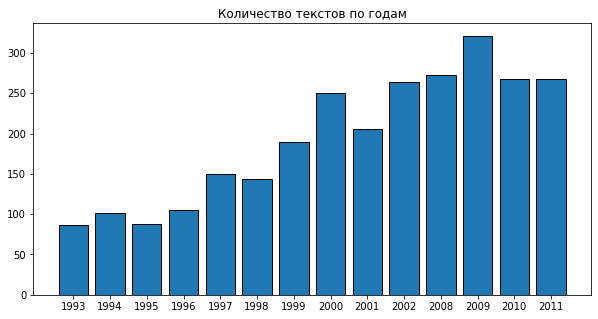

In [80]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(range(len(timeline_count)), timeline_count.values(), edgecolor='k')
ax.set_xticks(
    ticks=np.arange(0, len(list(timeline_count.keys()))),
    labels=list(timeline_count.keys())
)
ax.set_title('Количество текстов по годам')
;

# Тематическое моделирование

In [56]:
!rm -rf batches
!rm -f cv_wabbit*.vw vocab.txt

In [57]:
@check_path
def vocabulary_prep(text, vocab):
     with open(vocab, 'w') as fh:
        for sent in text:
            fh.write(' |text ' + sent + '\n')

In [58]:
# для всех текстов сразу
cv_vocab_path = 'cv_wabbit_v2.vw'
vocabulary_prep(texts_filtered, cv_vocab_path)

#### Подготовка бачтей

In [59]:
batch_vectorizer = batching(data_path=cv_vocab_path)

### Create an ARTM dictionary

In [60]:
dictionary = artm.Dictionary()
dictionary.gather(batch_vectorizer.data_path)

### Save / load dictionary

In [61]:
# !rm -f vocab.txt
dictionary.save_text('vocab_all_texts.txt')
# dictionary.load_text(dictionary_path='vocab_all_texts.txt')

### ARTM model initialization

[пример](https://www.coursera.org/learn/unsupervised-learning/supplement/suSWG/noutbuk-iz-diemonstratsii-ispol-zovaniia-bigartm)

In [62]:
T = 5  # число тем
tokens_per_T = 10 # число токенов в теме
num_collection_passes = 10  # число проходов по коллекции

In [63]:
def init_model_artm(dictionary=dictionary):
    model_artm = artm.ARTM(num_topics=T,
                           topic_names=[str(i + 1) for i in range(T)],
                           class_ids={"text":1},
                           reuse_theta=True, 
                           cache_theta=True,
                           num_document_passes=5,
                           seed=0)
    
    # add scorers
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore', dictionary=dictionary))
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id='text'))
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    model_artm.scores.add(artm.TopTokensScore(name='top_words', num_tokens=tokens_per_T, class_id='text'))
    
    model_artm.initialize(dictionary=dictionary)
    return model_artm

# model_artm = init_model_artm(dictionary)

`phi score`: разреженность матрицы распределения терминов в теме

`theta score`: разреженность матрицы распределения тем в документах


$\Phi$: `model_artm.get_phi()`
по столбцам стоят отдельные темы, по строкам - слова в коллекции, значение = P(w|t)

$\Theta$: `model_artm.get_theta()`
по столбцам - документы, по строкам - темы, значение = P(t|d)


### 0. Модель без регуляризаторов

In [64]:
model_artm = init_model_artm()
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                       num_collection_passes=num_collection_passes)

tokens_printer(model_artm)

show_matrices_sparsity(model_artm)

1: военнослужащий, память, перегрузка, вывих, стираемость, амплитуда, поле, мкв, металл, мыщелковый

2: дизокклюзия, подгруппа, мезиальна, асимметрия, дыхание, истирание, экологический, секстант, вестибулярный, ротация

3: небный, недостаток, питание, респондент, специалист, уранопластик, фтор, карта, замена, вопрос

4: платный, кабинет, работать, государственный, финансирование, труд, специалист, удельный, стандарт, вес

5: лимфатический, волокно, вокруг, деминерализация, желудок, пятно, фиброзный, гриб, мощность, проницаемость

Phi sparsity: 0.414
Theta sparsity: 0.171


### Regularizers: 1

[Decorrelator Phi](https://bigartm.readthedocs.io/en/stable/tutorials/regularizers_descr.html#decorrelator-phi)
* $\tau > 0 \rightarrow$ токены различаются сильные в разных темах
* $\tau < 0 \rightarrow$ токены в разных темах становятся более похожими друг на друга

In [72]:
%%time
model_artm = init_model_artm()
model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrPhi', tau=+1e3))
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

tokens_printer(model_artm)

show_matrices_sparsity(model_artm)

1: военнослужащий, память, перегрузка, вывих, стираемость, амплитуда, поле, мкв, металл, мыщелковый

2: дизокклюзия, подгруппа, мезиальна, асимметрия, дыхание, истирание, экологический, секстант, вестибулярный, ротация

3: небный, недостаток, питание, респондент, специалист, уранопластик, фтор, карта, замена, вопрос

4: платный, кабинет, работать, государственный, финансирование, труд, специалист, удельный, стандарт, вес

5: лимфатический, волокно, вокруг, деминерализация, желудок, пятно, фиброзный, гриб, мощность, проницаемость

Phi sparsity: 0.415
Theta sparsity: 0.171
CPU times: user 5.46 s, sys: 145 ms, total: 5.6 s
Wall time: 1.94 s


In [73]:
# theta_0 = model_artm.get_theta()
# theta_bins_0 = count_topics_in_collection(theta_0, TOPIC_PROBA_THRESHOLD)
# plot_collection_topic_distribution(theta_bins_0)

### Regularizers: 2
[SmoothSparsePhiRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#decorrelator-phi)
* $\tau > 0 \rightarrow$ сглаживает матрицу $\Phi$
* $\tau < 0 \rightarrow$ разрежает матрицу $\Phi$

* можно задавать `tau` без `dictionary` - тогда регуляризация для каждого слова в словаре будет одинаковой (разумные значения -2.5, -5)
* если задан `tau (<0) & dictionary` - чем более вероятно слово во всей коллекции (чем большую частоту оно имеет), тем менее вероятно оно будет входить в отдельные темы
* для применения регуляризатора к отдельным модальностям
```python
class_ids=['text']
```

In [74]:
model_artm = init_model_artm()
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-1e4, dictionary=dictionary))
# tau = -1e5: слово будет домножаться на его частоту во всей коллекции
# dictionary: str or reference to Dictionary object

model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

tokens_printer(model_artm)

show_matrices_sparsity(model_artm)

1: амплитуда, задний, металл, использоваться, секстант, лимфатический, интоксикация, поле, разрушение, память

2: категория, дыхание, затрата, подгруппа, синус, артерия, диспансерный, экологический, вестибулярный, укорочение

3: небный, недостаток, фтор, медико, щель, расширение, пространство, республика, центр, проекция

4: кабинет, платный, контактный, государственный, удельный, труд, технический, специалист, личностный, нуждаемость

5: волокно, специфический, мощность, консервативный, носить, созревание, фиброзный, деминерализация, ион, эпителизация

Phi sparsity: 0.761
Theta sparsity: 0.113


### Regularizers: 3

[SmoothThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#smooth-sparse-theta)

* $\tau > 0 \rightarrow$ сглаживает матрицу $\Theta$
* $\tau < 0 \rightarrow$ разрежает матрицу $\Theta$

Видно, что даже небольшое значение для регуляризатора [SmoothThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#smooth-sparse-theta) приводит к удалению некоторых тем

In [75]:
model_artm = init_model_artm()
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-10))
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
                      num_collection_passes=num_collection_passes)

tokens_printer(model_artm)
show_matrices_sparsity(model_artm)

1: фиссура, небный, созревание, пятно, перегрузка, поле, память, фтор, металл, питание

3: подгруппа, руб, вахтовый, старческий, стоимость, пища, личностный, диспансерный, пожилое, артерия

5: штифтовой, лимфатический, литовить, винтовой, гсу, начинать, расширение, узел, нсо, инфракрасный

Phi sparsity: 0.869
Theta sparsity: 0.915


### Regularizers: 4
[TopicSelectionThetaRegularizer](http://docs.bigartm.org/en/stable/tutorials/regularizers_descr.html#topic-selection-theta)

Читать(p.13) - ARTM_examples/4-1.Tematicheskoe_modelirovanie-_1.pdf

In [76]:
# model_artm.regularizers.add(artm.TopicSelectionThetaRegularizer(name='TopicSelectionTheta', tau=1))
# model_artm.regularizers['TopicSelectionTheta'].tau = 1

In [77]:
# model_artm.fit_offline(batch_vectorizer=batch_vectorizer,
#                       num_collection_passes=num_collection_passes)

In [78]:
# tokens_printer(model_artm)

In [79]:
# show_matrices_sparsity(model_artm)